<a href="https://colab.research.google.com/github/mimi1981/SIOS_workshop/blob/main/Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Aim: short notebook for SIOS hands on training 
Author: Weibin Chen + Michel 
Date: August 2022

In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import math

# Functions needed

In [ ]:
#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================


def peakiness(waves, **kwargs):  
    
    "finds peakiness of waveforms." 

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \
     
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")
    size=np.shape(waves)[0]
    
    waves1=np.copy(waves)
    
    if waves1.ndim == 1:
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1))
        waves1=waves2

    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky')

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):
        
    from scipy.interpolate import interp1d
        
    time_1hz=SAR_data.variables['time_counter_1Hz'][:]
    time_20hz=SAR_data.variables['time_counter_20Hz'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan) 
        
    if len(out)==len(time_1hz):
            
        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)  

    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    from scipy import asarray as ar,exp
    do_plot='Off'
    
    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])
    
    for i in range(np.shape(RIP)[0]):
    
        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)                          
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])
            
    
    return SSD
#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def mlp_block(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units)(x)
        x = layers.Activation('gelu')(x)
        x = layers.Dropout(rate = dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
#=========================================================================================================
#=========================================================================================================
#=========================================================================================================
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, pro_dimen):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=pro_dimen)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=pro_dimen
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================
def transformer_block(pa):
  encoded_patches = PatchEncoder(num_patches, pro_dimen)(pa)
  for _ in range(num_layers):
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
          
    attention_output = layers.MultiHeadAttention(
    num_heads=num_heads, key_dim=pro_dimen, dropout=0.1
          )(x1, x1)    
    x2 = layers.Add()([attention_output, encoded_patches])
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = mlp_block(x3, hidden_units=transformer_units, dropout_rate=0.1)
    
    encoded_patches = layers.Add()([x3, x2])
  extraction = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  extraction = layers.Flatten()(extraction)
  extraction = layers.Dropout(0.5)(extraction)

  return extraction


def vit():
    inputs = keras.Input(shape=input_shape)
    data_plus = more_data(inputs)
    patches = Patches(patch_size)(data_plus)
    encoded_patches = PatchEncoder(num_patches, pro_dimen)(patches)
    extraction = transformer_block(pa=patches)
    features = mlp_block(extraction, mlp_heads,0.3)
    output = layers.Dense(num_classes)(features)
    model = keras.Model(inputs = inputs, outputs = output)
    return model

  
#=========================================================================================================
#=========================================================================================================
#=========================================================================================================
def run_experiment(model):
    model.compile(
        optimizer=tfa.optimizers.AdamW(
learning_rate=learning_rate, weight_decay=wei_dec
    ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),],
    )

    filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(x=x_train,y=y_train,batch_size=30,epochs=20,validation_split=0.1,callbacks=[checkpoint_callback],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    

    return history


# Data


In [ ]:
#y_train.npy
! gdown --id 1xijuIvlUw7Y9_USNiE9lIBYO0-MhR1VG

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1xijuIvlUw7Y9_USNiE9lIBYO0-MhR1VG
To: /content/y_train.npy
100% 11.9k/11.9k [00:00<00:00, 18.1MB/s]


In [ ]:
#y_test.npy
! gdown --id 1pDvdFdmbbwd5QjyXcaiaDNiKfTW7_7gh

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1pDvdFdmbbwd5QjyXcaiaDNiKfTW7_7gh
To: /content/y_test.npy
100% 5.42k/5.42k [00:00<00:00, 10.5MB/s]


In [ ]:
#x_train.npy
! gdown --id 1teFyjdZIIvgDR6C_AcBult2UAcPw1FLv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1teFyjdZIIvgDR6C_AcBult2UAcPw1FLv
To: /content/x_train.npy
100% 269M/269M [00:01<00:00, 262MB/s]


In [ ]:
#x_test.npy
! gdown --id 1ORMYfhe1Mo9q9gYASJnUcWsw3MLI3nRY

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ORMYfhe1Mo9q9gYASJnUcWsw3MLI3nRY
To: /content/x_test.npy
100% 121M/121M [00:00<00:00, 275MB/s]


In [ ]:
!ls /content/

sample_data  x_test.npy  x_train.npy  y_test.npy  y_train.npy


In [ ]:
# # from google.colab import drive
# # drive.mount('/content/drive')

# !ls /content/drive/MyDrive/SIOS_training/DATA2

x_test.npy  x_train.npy  y_test.npy  y_train.npy


In [ ]:
import numpy as np
##Process the data separately and load them since processing the data takes quite some time and we don't want to process it evertime we run the model
x_test = np.load('/content/x_test.npy')
x_train  = np.load('./x_train.npy')
y_test  = np.load('/content/y_test.npy')
y_train  = np.load('/content/y_train.npy')

In [ ]:
x_train.shape

(1469, 33, 33, 21)

# Random forest

In [ ]:
#Reshape the data to adapt to the required shape of input of random forest
nsamples, nx, ny, nrgb = x_train.shape
x_train2 = x_train.reshape((nsamples,nx*ny*nrgb))

In [ ]:
x_test.shape

(662, 33, 33, 21)

In [ ]:
x_train2.shape

(1469, 22869)

In [ ]:
import matplotlib.pyplot as plt

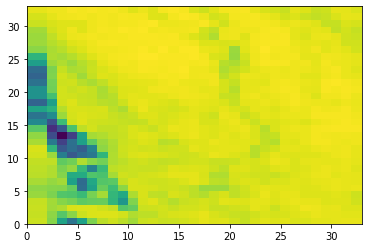

In [ ]:
plt.pcolor(x_train[300,:,:,0])

In [ ]:
y_train[300]

0.0

In [ ]:
#Implement random forest
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
model.fit(x_train2,y_train)

RandomForestClassifier()

In [ ]:
#Test the model on test set and print the corresponding accuracy
nsamples, nx, ny, nrgb = x_test.shape
x_test2 = x_test.reshape((nsamples,nx*ny*nrgb))
y_pred=model.predict(x_test2)
print(y_pred)
print(y_test)
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print(accuracy_score(y_pred,y_test))

[0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.

# Vision transformer

In [ ]:
#Store all the hyperparameters here
num_classes = 2 #Can be changed to multi-classed classification
input_shape = (33, 33, 21)#depends on the size of the image we want
num_epo = 100
ima_size = 96
patch_size = 12  
num_patches = (ima_size//patch_size)**2
pro_dimen = 64
num_heads = 4
wei_dec = 0.001
batch_size = 128
num_layers = 32
mlp_heads = [2048, 1024]  
transformer_units = [pro_dimen * 2,pro_dimen,] 
learning_rate = 0.001

In [ ]:

more_data = keras.Sequential(
    [layers.Normalization(),layers.Resizing(ima_size, ima_size),layers.RandomZoom(height_factor=0.2, width_factor=0.2),],
    name="more_data",)
more_data.layers[0].adapt(x_train)

In [ ]:
vit = vit()
history = run_experiment(vit)

Epoch 1/20
45/45 [==============================] - 49s 245ms/step - loss: 1.8369 - accuracy: 0.6536 - val_loss: 0.3761 - val_accuracy: 0.8367
Epoch 2/20
45/45 [==============================] - 7s 164ms/step - loss: 0.4456 - accuracy: 0.7806 - val_loss: 0.3301 - val_accuracy: 0.8571
Epoch 3/20
45/45 [==============================] - 6s 131ms/step - loss: 0.3855 - accuracy: 0.8230 - val_loss: 0.4049 - val_accuracy: 0.8299
Epoch 4/20
45/45 [==============================] - 7s 157ms/step - loss: 0.3595 - accuracy: 0.8585 - val_loss: 0.2531 - val_accuracy: 0.9048
Epoch 5/20
45/45 [==============================] - 7s 157ms/step - loss: 0.2947 - accuracy: 0.8858 - val_loss: 0.2012 - val_accuracy: 0.9184
Epoch 6/20
45/45 [==============================] - 6s 132ms/step - loss: 0.3024 - accuracy: 0.8797 - val_loss: 0.3079 - val_accuracy: 0.8571
Epoch 7/20
45/45 [==============================] - 7s 155ms/step - loss: 0.2712 - accuracy: 0.8896 - val_loss: 0.1833 - val_accuracy: 0.9320
Epoch

In [ ]:
#Run the model on test set (although the accuracy has been already calculated in training process )
y_pred=vit.predict(x_test)
#print(y_pred)
print(np.argmax(y_pred,axis = 1))
print(y_test)


[0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0
 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0
 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1
 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0
 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0
 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0
 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1
 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1
 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0
 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1
 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 0 1 1 